###**Задание**

1. Провести сегментацию клиентов используя три признака одновременно ("Age", "Annual Income", "Spending Score"). Визуализировать результаты в 3D.
2. Применить k-means++ и стандартный k-means с разными random_state. Сравнить стабильность результатов через несколько запусков.
3. Проанализировать выбросы в данных, удалить их и сравнить результаты кластеризации до и после удаления выбросов.
4. Использовать метод силуэта для оценки качества кластеризации при разных k (от 2 до 8) и визуализировать силуэтные коэффициенты.
5. Создать новые признаки (например, отношение расходов к доходам) и провести кластеризацию с включением этих признаков. Сравнить с базовой моделью.

In [ ]:
# 1 Установка и импорт библиотек

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 2 Скачиваем датасет через wget

!wget https://storage.yandexcloud.net/academy.ai/Mall_Customers.csv
df = pd.read_csv("Mall_Customers.csv")

--2025-06-06 00:28:50--  https://storage.yandexcloud.net/academy.ai/Mall_Customers.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3981 (3.9K) [text/csv]
Saving to: ‘Mall_Customers.csv’

Mall_Customers.csv  100%[===================>]   3.89K  --.-KB/s    in 0s      

2025-06-06 00:28:51 (1.13 GB/s) - ‘Mall_Customers.csv’ saved [3981/3981]



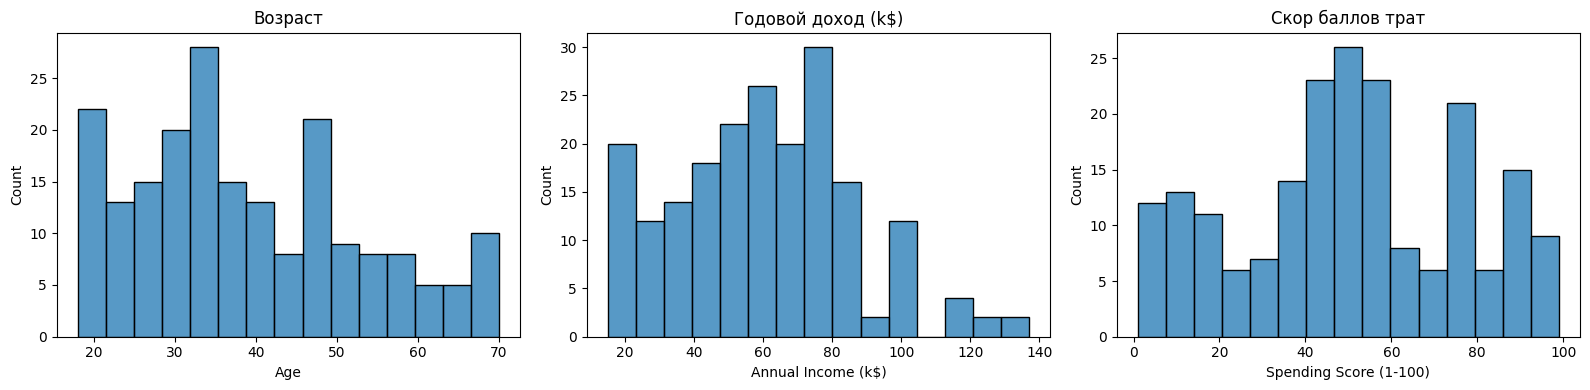

In [ ]:
# 3. Визуализация распределений признаков

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.histplot(df['Age'], bins=15)
plt.title('Возраст')

plt.subplot(1,3,2)
sns.histplot(df['Annual Income (k$)'], bins=15)
plt.title('Годовой доход (k$)')

plt.subplot(1,3,3)
sns.histplot(df['Spending Score (1-100)'], bins=15)
plt.title('Скор баллов трат')

plt.tight_layout()
plt.show()

In [ ]:
# 4 Масштабирование данных по трем признакам
from sklearn.preprocessing import StandardScaler
X3d = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
X3d_scaled = scaler.fit_transform(X3d)

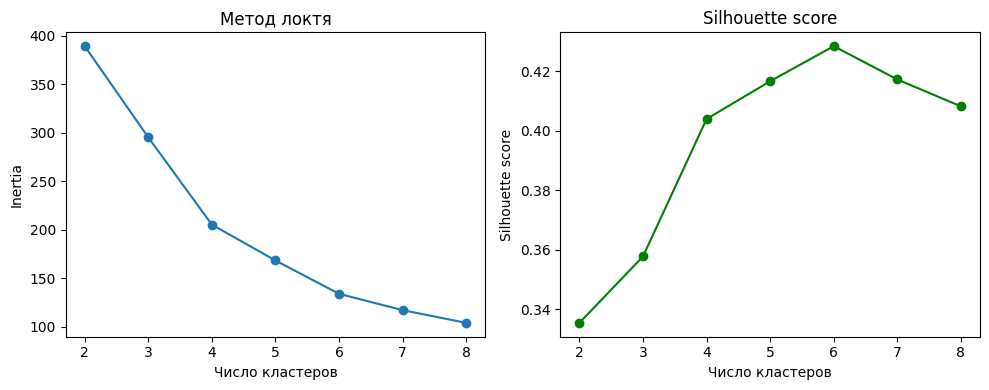

In [ ]:
# 5 Подбор количества кластеров методом локтя и методом силуэта
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette_scores = []
ks = range(2, 9)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X3d_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X3d_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(ks, silhouette_scores, marker='o', color='green')
plt.title('Silhouette score')
plt.xlabel('Число кластеров')
plt.ylabel('Silhouette score')
plt.tight_layout()
plt.show()

k_opt = 5

In [ ]:
# 6 Кластеризация: сравнение k-means++ и random init с разными random_state
results = []
for random_state in [0, 42, 99]:
    for init in ['random', 'k-means++']:
        kmeans = KMeans(n_clusters=k_opt, init=init, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X3d_scaled)
        inertia = kmeans.inertia_
        sil = silhouette_score(X3d_scaled, labels)
        results.append({'init': init, 'random_state': random_state, 'inertia': inertia, 'silhouette': sil})

results_df = pd.DataFrame(results)
print("Сравнение разных инициализаций и random_state:")
display(results_df)

Сравнение разных инициализаций и random_state:


,init,random_state,inertia,silhouette
0,random,0,168.24758,0.416643
1,k-means++,0,168.24758,0.416643
2,random,42,168.24758,0.416643
3,k-means++,42,168.24758,0.416643
4,random,99,168.24758,0.416643
5,k-means++,99,168.24758,0.416643


In [ ]:
# 7 Кластеризация с оптимальным числом кластеров
kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(X3d_scaled)
df['Cluster'] = labels_final

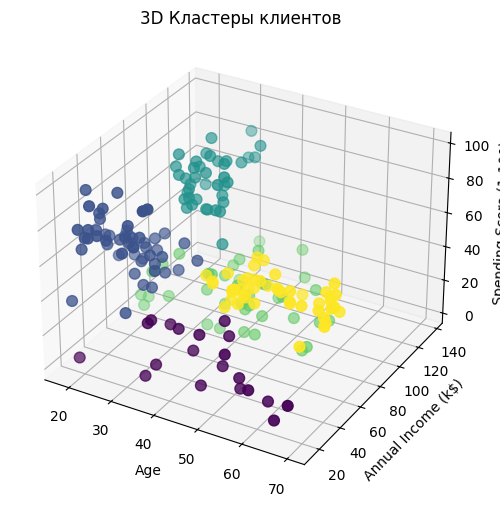

In [ ]:
# 8 3D визуализация
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'],
    c=df['Cluster'], cmap='viridis', s=60
)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.title('3D Кластеры клиентов')
plt.show()

Удалено выбросов: 18


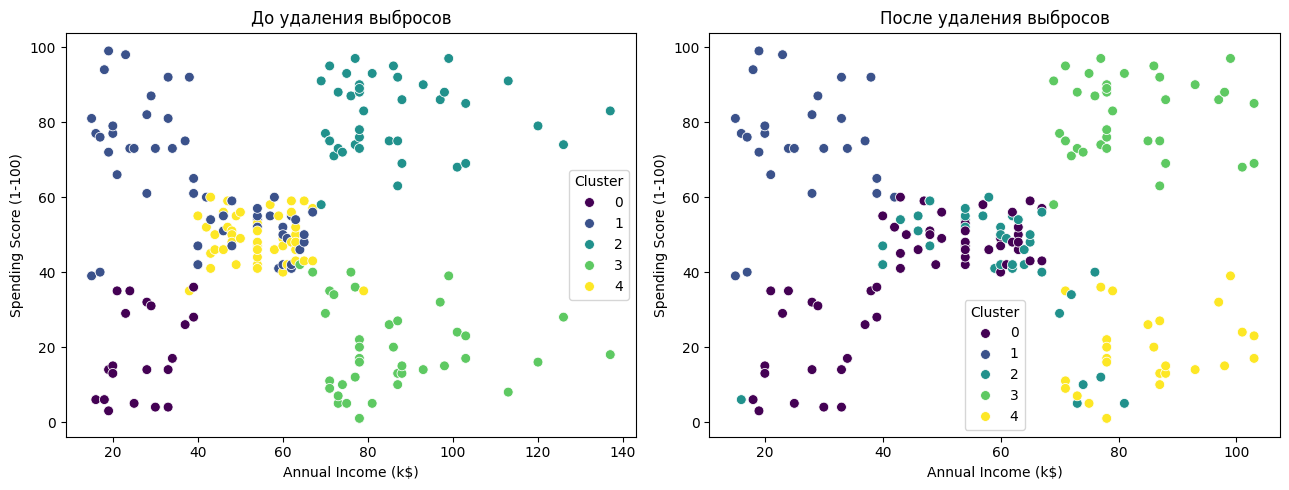

In [ ]:
# 9 Анализ выбросов по всем признакам (z-score)
from scipy.stats import zscore
import numpy as np

z_scores = np.abs(zscore(X3d))
mask = (z_scores < 2).all(axis=1)
print(f"Удалено выбросов: {len(df) - mask.sum()}")
df_clean = df[mask].copy()

# Кластеризация после удаления выбросов
X3d_clean_scaled = scaler.fit_transform(df_clean[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
kmeans_clean = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels_clean = kmeans_clean.fit_predict(X3d_clean_scaled)
df_clean['Cluster'] = labels_clean

# 2D сравнение кластеров ДО и ПОСЛЕ очистки
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='Cluster', data=df, palette='viridis', s=50
)
plt.title('До удаления выбросов')
plt.subplot(1,2,2)
sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='Cluster', data=df_clean, palette='viridis', s=50
)
plt.title('После удаления выбросов')
plt.tight_layout()
plt.show()

In [ ]:
# 10 Новый признак — отношение расходов к доходу
df['Spend_to_Income'] = df['Spending Score (1-100)'] / (df['Annual Income (k$)'] + 1)
X_new = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Spend_to_Income']]
X_new_scaled = scaler.fit_transform(X_new)
kmeans_new = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels_new = kmeans_new.fit_predict(X_new_scaled)
df['Cluster_with_new'] = labels_new

print("Сравнение средних по кластерам с новым признаком (Spend_to_Income):")
display(df.groupby('Cluster_with_new')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Spend_to_Income']].mean())

Сравнение средних по кластерам с новым признаком (Отношение_трат_к_доходу):


,Возраст,Годовой доход (тыс. р),Скор баллов трат,Отношение_трат_к_доходу
Кластер_с_новым_признаком,,,,
0,55.551724,48.482759,41.775862,0.833293
1,25.304348,24.304348,76.521739,3.213187
2,32.692308,86.538462,82.128205,0.965694
3,28.000000,51.239130,45.304348,0.899679
4,41.264706,88.500000,16.764706,0.187689


In [ ]:
# 11 Вывод финальных таблиц
print('Таблица первых 5 клиентов с кластером:')
display(df.head())

print('Краткая финальная информация:')
display(df.info())
display(df.describe())


Таблица первых 5 клиентов с кластером:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Spend_to_Income,Cluster_with_new
0,1,Male,19,15,39,1,2.437500,1
1,2,Male,21,15,81,1,5.062500,1
2,3,Female,20,16,6,0,0.352941,3
3,4,Female,23,16,77,1,4.529412,1
4,5,Female,31,17,40,1,2.222222,1


Краткая финальная инфа:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Gender                  200 non-null    object 
 2   Age                     200 non-null    int64  
 3   Annual Income (k$)      200 non-null    int64  
 4   Spending Score (1-100)  200 non-null    int64  
 5   Cluster                 200 non-null    int32  
 6   Spend_to_Income         200 non-null    float64
 7   Cluster_with_new        200 non-null    int32  
dtypes: float64(1), int32(2), int64(4), object(1)
memory usage: 11.1+ KB


None

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Cluster,Spend_to_Income,Cluster_with_new
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000,2.195000,1.038315,1.875000
std,57.879185,13.969007,26.264721,25.823522,1.332612,0.923452,1.476576
min,1.000000,18.000000,15.000000,1.000000,0.000000,0.012658,0.000000
25%,50.750000,28.750000,41.500000,34.750000,1.000000,0.614648,0.000000
50%,100.500000,36.000000,61.500000,50.000000,2.000000,0.875283,2.000000
75%,150.250000,49.000000,78.000000,73.000000,3.000000,1.105364,3.000000
max,200.000000,70.000000,137.000000,99.000000,4.000000,5.062500,4.000000
